In [1]:
import pandas as pd
from pandas import datetime

def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")

data = pd.read_csv('Sales_Data.csv', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)
data

C:\Users\koush\anaconda3\envs\LSBU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


date
2013-01-01    1742
2013-01-02    1808
2013-01-03    1887
2013-01-04    1983
2013-01-05    2087
              ... 
2017-12-27    2624
2017-12-28    2839
2017-12-29    3025
2017-12-03    3151
2017-12-31    3370
Name: sales, Length: 1826, dtype: int64

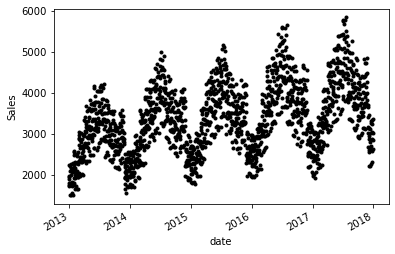

In [2]:
#Visualise data 
import matplotlib.pyplot as plt
%matplotlib inline

data = data.astype(float)
data
data.plot(style='k.',ylabel='Sales')
plt.show()

In [3]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
from pandas import datetime

data = np.array(data)
data = np.reshape(data, (-1, 1))
data

C:\Users\koush\anaconda3\envs\LSBU\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


array([[1742.],
       [1808.],
       [1887.],
       ...,
       [3025.],
       [3151.],
       [3370.]])

In [4]:
#splitting data into test and train parts, Forecasting demand for last 3 months, (have to consider 3 months + 14 days to account for input features)
m= 14
per = (1736 - m)/1826
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]

mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train


In [5]:
print(d_train.shape)
print(d_test.shape)

(1722, 1)
(104, 1)


In [6]:
#auto corrected input vector for training (we are taking 14 lagged values as features for each data point)
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])

for i in range(1,(d_train.shape[0]-m)):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    X_train = np.vstack([X_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
    
#auto corrected input vector for test
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])

for i in range(1,(d_test.shape[0]-m)):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    X_test = np.vstack([X_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])
    
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1708, 14)
(1708, 1)
(90, 14)
(90, 1)


Test RMSE: 195.619
Test MAPE: 3.307
Test MPE: -0.888


(array([2000., 2500., 3000., 3500., 4000., 4500., 5000.]),
 <a list of 7 Text yticklabel objects>)

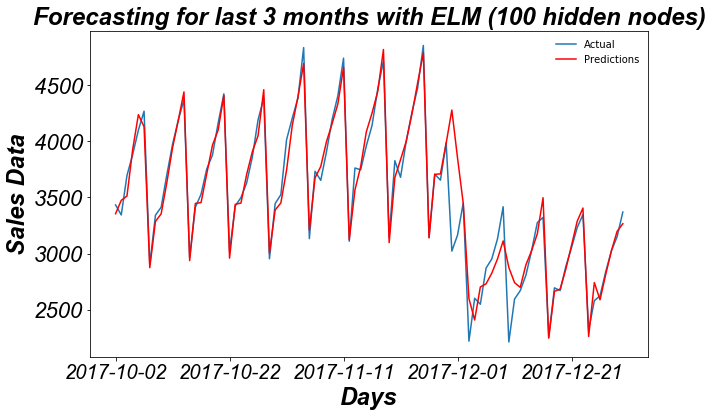

In [7]:
import scipy.stats as stats

input_size = X_train.shape[1]
hidden_size = 100   #no. of hidden neurons

mu, sigma = 0, 1
w_lo = -1 
w_hi = 1
b_lo = -1 
b_hi = 1
#initialising input weights and biases randomly drawn from a truncated normal distribution
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
        
def relu(x):      #hidden layer activation function
    return np.maximum(x, 0, x)
    
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

prediction = predict(X_test)
correct = 0
total = X_test.shape[0]
    
y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train

# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i,j in zip(y_test,prediction):
    mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i,j in zip(y_test,prediction):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)

# plot forecasts against actual outcomes
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(y_test,label = 'Actual')
ax.plot(prediction, color='red',label = 'Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('Sales Data',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Forecasting for last 3 months with ELM (100 hidden nodes)',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.xticks([0,20,40,60,80],['2017-10-02','2017-10-22','2017-11-11','2017-12-01','2017-12-21'],fontname="Arial", fontsize = 20, style='italic')
plt.yticks(fontname="Arial", fontsize = 22, style='italic')